In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from pennylane.templates import RandomLayers
from sklearn import datasets
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Sequential, Linear, LeakyReLU, Sigmoid
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchsummary import summary

import time
import datetime
from tqdm import tqdm

2023-01-03 18:05:29.958799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 18:05:29.958850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# # Choosing the device
device = torch.device("cpu")

# # Setting the random seed 
# seed = 43
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = 'torch_results/GAN/GAN_linear/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(save_path)

2023-01-03 18:05:32.752862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 18:05:32.752905: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 18:05:32.752926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-01-03 18:05:32.753194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def resize_data(x, y, label, image_size):

    arr = []
    arr_input = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            arr.append((t, l))
            arr_input.append(t)
    return arr, arr_input

In [5]:
noise_dim = 5
image_size = 8
batch_size = 1

In [6]:
#load dataset and create a batch
digits, targets = datasets.load_digits(return_X_y=True)
# digits /= 16
# dataloader = DataLoader(list(zip(digits.astype("float32"), targets.astype("float32"))), 
#                         batch_size= batch_size, shuffle= True, drop_last= True)

rd, inp = resize_data(digits, targets, label = (0,), image_size = image_size)
dataloader = torch.utils.data.DataLoader(rd, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# #show the first iteration batch
# images, labels = next(iter(dataloader))
# plt.figure()
# f, axarr = plt.subplots(8,8, figsize=(10,10)) 
# for i, ax in enumerate(axarr.ravel()):
#     ax.imshow(images[i].reshape(8,8), cmap = 'gray')
#     ax.tick_params(left=False,
#                 bottom=False,
#                 labelleft=False,
#                 labelbottom=False)
#     ax.set_title(f"Num:{labels[i]}")
# f.tight_layout()
# plt.show()

In [8]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.dense_layer = nn.Linear(self.z_dim, 32)
        self.relu = nn.LeakyReLU()
        self.lin = nn.Linear(32, 64)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.dense_layer(x)
        x = self.relu(x)
        x = self.lin(x)
        x = self.activation(x)
        return x#self.activation(self.dense_layer(x))

In [9]:
generator = Generator(noise_dim).to(device)
summary(generator, (1, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             192
         LeakyReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 64]           2,112
           Sigmoid-4                [-1, 1, 64]               0
Total params: 2,304
Trainable params: 2,304
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [10]:
n_qubits = 5

@qml.qnode(qml.device("lightning.qubit", wires=n_qubits), interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise, gen_weights, gen_n_layers, n_qubits):

    gen_weights = gen_weights.reshape(gen_n_layers, n_qubits)

    # Encoding layer
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    #qml.AngleEmbedding(noise, wires=range(n_qubits))

    # PQC layers
    for i in range(gen_n_layers):

        # Rotation gates
        for y in range(n_qubits):
            #for w in range(n_gate_per_layer):
            #qml.RX(gen_weights[i][y], wires=y)  
            qml.RY(gen_weights[i][y], wires=y)   
            #qml.RZ(gen_weights[i][y], wires=y) 

    #RandomLayers(gen_weights, wires = list(range(n_qubits)), ratio_imprim = 0.1)
            
        # Entangling gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    # Returning probability of each computational basis state
    return qml.probs(wires=list(range(n_qubits)))



class QuantumGenerator(nn.Module):

    def __init__(self, n_qubits, ancillary_qubits, gen_n_layers, n_generators, device, q_delta=1):
        super(QuantumGenerator, self).__init__()

        self.n_qubits = n_qubits
        self.ancillary_qubits = ancillary_qubits
        self.gen_n_layers = gen_n_layers
        #self.n_gate_per_layer = n_gate_per_layer
        self.n_generators = n_generators
        self.device = device
        self.vqc_params = nn.ParameterList([nn.Parameter(q_delta * torch.rand(self.gen_n_layers * self.n_qubits), 
                                          requires_grad=True)for _ in range(self.n_generators)])

    def forward(self, x):
        
        patch_size = 2 ** (self.n_qubits - self.ancillary_qubits)

        images = torch.Tensor(x.size(0), 0).to(self.device)

        # Iterate over all sub-generators
        for params in self.vqc_params:
            
            patches = torch.Tensor(0, patch_size).to(self.device)
            for elem in x:
                
                probs = quantum_generator_circuit(elem, params, self.gen_n_layers, self.n_qubits)
                partial_measure = probs[: (2 ** (n_qubits - self.ancillary_qubits))]
                partial_measure /= torch.sum(probs)
            
                out = partial_measure / torch.max(partial_measure)
                out = out.float().unsqueeze(0)
                patches = torch.cat((patches, out))

            # Building the image
            images = torch.cat((images, patches), 1)
            #print(images.shape)

        return images

In [11]:
class Discriminator(nn.Module):

    def __init__(self, image_size):
        super(Discriminator, self).__init__()

        self.image_size = image_size
        self.linear1 = nn.Linear(self.image_size * self.image_size, 64)
        self.relu1 = nn.LeakyReLU()
        #self.linear2 = nn.Linear(64, 16)
        #self.relu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.linear1(x)
        x = self.relu1(x)
        #x = self.linear2(x)
        #x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)

        return x

In [12]:
# class Discriminator(nn.Module):
#     """Fully connected classical discriminator"""

#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             # Inputs to first hidden layer (num_input_features -> 64)
#             nn.Linear(8*8, 64),
#             nn.ReLU(),
#             # First hidden layer (64 -> 16)
#             nn.Linear(64, 16),
#             nn.ReLU(),
#             # Second hidden layer (16 -> output)
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.model(x)

In [13]:
class GAN():
    def __init__(self, network_type, dataloader, gen_net, disc_net, noise_dim, image_size, batch_size, loss, lr_gen, lr_disc, device, save_path):

        self.network_type = network_type
        self.dataloader = dataloader
        self.gen_net = gen_net
        self.disc_net = disc_net
        self.noise_dim = noise_dim 
        self.image_size = image_size
        self.batch_size = batch_size
        self.lr_gen = lr_gen
        self.lr_disc = lr_disc
        self.loss = loss
        self.device = device
        self.save_path = save_path

        self.gen_opt = optim.SGD(self.gen_net.parameters(), lr=self.lr_gen)
        self.disc_opt = optim.SGD(self.disc_net.parameters(), lr=self.lr_disc)        

        self.real_labels = torch.full((self.batch_size,), 1.0, dtype=torch.float, device=self.device)
        self.fake_labels = torch.full((self.batch_size,), 0.0, dtype=torch.float, device=self.device)

        self.loss_g = []
        self.loss_d = []

    
    def train_step(self, data):

        # Data for training the discriminator
        data = data.reshape(-1, self.image_size * self.image_size)
        real_data = data.to(self.device)

        # Generating noise
        noise = torch.rand(self.batch_size, self.noise_dim, device=self.device) * np.pi / 2
        fake_data = self.gen_net(noise)

        #---------------- Discriminator training ----------------# 
        self.disc_opt.zero_grad()
        disc_out_real = self.disc_net(real_data).view(-1)
        disc_out_fake = self.disc_net(fake_data.detach()).view(-1)

        disc_error_real = self.loss(disc_out_real, self.real_labels)
        disc_error_fake = self.loss(disc_out_fake, self.fake_labels)
        
        disc_error_real.backward()
        disc_error_fake.backward()

        disc_error = disc_error_real + disc_error_fake
        self.disc_opt.step()

        #---------------- Generator training ----------------#
        self.gen_opt.zero_grad()
        # Generating fake images
        #noise = torch.rand(self.batch_size, self.noise_dim)
        #fake_data = self.gen_net(noise)
        disc_out_fake = self.disc_net(fake_data).view(-1)
        gen_error = self.loss(disc_out_fake, self.real_labels)
        gen_error.backward()
        self.gen_opt.step()        

        self.loss_g.append(gen_error.item())
        self.loss_d.append(disc_error.item())

        return gen_error, disc_error


    def learn(self, epochs):

        # Fixed noise to visually track the generated images throughout training
        fixed_noise = torch.rand(8, self.noise_dim, device=self.device) * np.pi / 2

        # Iteration counter
        #counter = 0

        # Collect images for plotting later
        self.results = []
        
        self.ep_d_loss = []
        self.ep_g_loss = []    
                      
        
        with tqdm(range(epochs)) as tepochs:#total=len(self.dataloader), ncols=140, desc=f'epoch {epoch}') as bar:

            for epoch in tepochs:

                self.loss_g = []
                self.loss_d = []     
        
                for data, _ in self.dataloader:

                    lg, ld = self.train_step(data)

                    #counter += 1

                    # Show loss values         
                    #if epoch % 10 == 0:
                     

                    # if epoch == epochs:
                    #     break

                    self.loss_g.append(lg.item())
                    self.loss_d.append(ld.item())                    
                    
                    #bar.update(1)
                    #bar.set_postfix({'Generator loss' : lg.item(), 'Discriminator loss': ld.item()})
                
                #print(f'Iteration: {counter}, Discriminator Loss: {ld:0.3f}, Generator Loss: {lg:0.3f}')
                test_images = self.gen_net(fixed_noise).view(8,1,self.image_size,self.image_size).cpu().detach()
                if self.network_type == 'Classical_linear':
                    torch.save(self.gen_net, self.save_path + f'lin_gen_epoch_{epoch}')
                elif self.network_type == 'Quantum_linear':
                    torch.save(self.gen_net, self.save_path + f'lin_q_gen_epoch_{epoch}')
                else:
                    print('Typology not admitted.')
                
                # Save images every 50 iterations
                #if epoch % 50 == 0:
                self.results.append(test_images)
                torch.save(self.results, self.save_path + 'synthetic.pt')  

                self.ep_g_loss.append(np.mean(self.loss_g))
                self.ep_d_loss.append(np.mean(self.loss_d))
                torch.save(self.ep_g_loss, self.save_path + 'gen_loss.pt') 
                torch.save(self.ep_d_loss, self.save_path + 'disc_loss.pt')  

                
                tepochs.set_postfix({'Generator loss' : np.mean(self.loss_g), 'Discriminator loss': np.mean(self.loss_d)})

            # if epoch == epochs:
            #     break

In [14]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = 'torch_results/GAN/GAN_linear/' + current_time + '/'
qsave_path = 'torch_results/QGAN/QGAN_linear/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(save_path)

noise_dim = 5
image_size = 8
batch_size = 1
loss = nn.BCELoss()
lr_gen = 0.3#0.03# 0.001
lr_disc = 0.01#0.001
epochs = 3
n_qubits = 5 
ancillary_qubits = 1  
gen_n_layers = 6  
n_generators = 4 

In [15]:
discriminator = Discriminator(image_size).to(device)
qgenerator = QuantumGenerator(n_qubits, ancillary_qubits, gen_n_layers, n_generators, device).to(device)
generator = Generator(noise_dim).to(device)

In [16]:
gan = GAN(network_type = 'Classical_linear', dataloader = dataloader, gen_net = generator, disc_net = discriminator, noise_dim = noise_dim, image_size = image_size, batch_size = batch_size, loss = loss,
          lr_gen = lr_gen, lr_disc = lr_disc, device = device, save_path = save_path)

gan.learn(epochs)

100%|██████████| 3/3 [00:00<00:00,  5.99it/s, Generator loss=0.725, Discriminator loss=1.38]


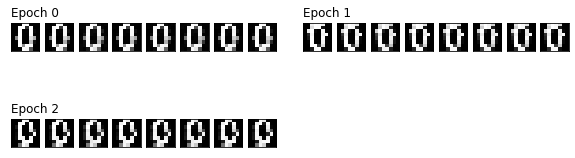

In [17]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(len(gan.results), 2, wspace=0.1)

for i, images in enumerate(gan.results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0), subplot_spec=outer[i])
    
    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Epoch {i}', loc='left')
        fig.add_subplot(ax)

plt.show()

<Figure size 432x288 with 0 Axes>

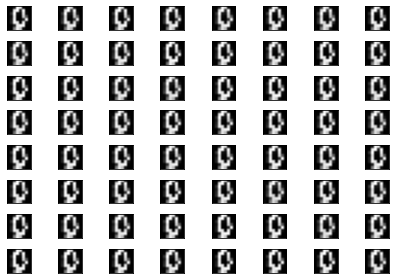

In [18]:
plt.figure()
f, axarr = plt.subplots(8, 8) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(generator(torch.rand(1,noise_dim)).detach().numpy().reshape(8,8), cmap = 'gray')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
f.tight_layout()
plt.show()

In [19]:
generator, generator(torch.rand(1,noise_dim)).shape

(Generator(
   (dense_layer): Linear(in_features=5, out_features=32, bias=True)
   (relu): LeakyReLU(negative_slope=0.01)
   (lin): Linear(in_features=32, out_features=64, bias=True)
   (activation): Sigmoid()
 ),
 torch.Size([1, 64]))

<Figure size 432x288 with 0 Axes>

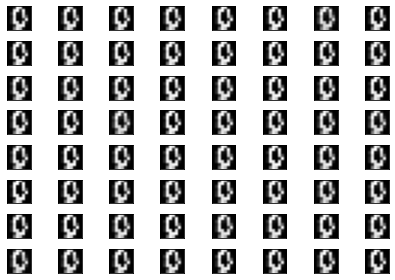

In [21]:
model = torch.load('torch_results/GAN/GAN_linear/20230103-180533/lin_gen_epoch_2')   # '0' features

#model = torch.load('torch_results/GAN/GAN_conv/20221229-091505/conv_gen_epoch_2000')

#model = torch.load('torch_results/GAN/GAN_linear/20221219-092917/gen_epoch_1500') # '0','1' features
#model = torch.load('torch_results/GAN/GAN_linear/20221219-100153/gen_epoch_2000')  # '0','1','2' features
#model.eval()

# GAN_imgs = []

# fixed_noise = torch.rand(1, 5) 
# for i in range(len(real_data)):      
     
#     image = model(fixed_noise).view(1,8,8).cpu().detach()
#     GAN_imgs.append(image)

# show_images(GAN_imgs, 8), GAN_imgs[0].shape

noise_dim = 5

plt.figure()
f, axarr = plt.subplots(8, 8) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(model(torch.rand(1,noise_dim)).detach().numpy().reshape(8,8), cmap = 'gray')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
f.tight_layout()
plt.show()

In [22]:
model, model(torch.rand(1,noise_dim)).shape

(Generator(
   (dense_layer): Linear(in_features=5, out_features=32, bias=True)
   (relu): LeakyReLU(negative_slope=0.01)
   (lin): Linear(in_features=32, out_features=64, bias=True)
   (activation): Sigmoid()
 ),
 torch.Size([1, 64]))

In [ ]:
x = np.arange(len(gan.loss_d))
plt.plot(x, gan.loss_d, label = "Discriminator loss")
plt.plot(x, gan.loss_g, label = "Generator loss")
plt.legend()
plt.show()